# Analysis

This notebook analyses the final set of papers found by the snowballing and coding selection process. 

The list of papers analysied is the spreadsheet CodedPapers.xlsx, containing the results of coding all the rounds.

Copyright &copy; 2021.   
Shared under the Apache 2.0 License

In [1]:
# !pip install google-search-results
from serpapi import GoogleScholarSearch
from ScholarUtils import GetPapers, GetPaper, WellCitedPapers, InitScholar, RelatedQuery, RelatedRef, NumCitations

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sns
import os
import statsmodels.stats.inter_rater as ir
import networkx as nx
# Warnings break anonymization...
import warnings
warnings.filterwarnings('ignore')

# Change to an appropriate location:
imageDir='.' 

# Some image defaults:
sns.set_palette("colorblind")
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = 8,4

# Reload ScholarUtils every time before executing code 
%load_ext autoreload
%autoreload 2

def Savefig(identifier):
    # Save the current image as an image file identified by the string identifier
    plt.savefig( os.path.join(imageDir, identifier + '.pdf'), bbox_inches='tight' ) 

In [3]:
InitScholar("APIKey.yaml")

In [4]:
# Get all the coded papers, and filter out those we've accepted:
allPreviousPapersDf=pd.read_excel('CodedPapers.xlsx', 
                                # Want Key as string, not number, to match WellCitedPapers() output:
                              dtype={'Key':np.str_}) 
acceptedPapersDf=allPreviousPapersDf.query('AgreedScore>6').copy()
print(len(acceptedPapersDf))
acceptedPapersDf

39


,Unnamed: 0,Key,Round,Citations,Year,Title,Authors,Link,Related,Snippet,C,P,AgreedScore,Unnamed: 13
0,0,2158158161114378793,1,123,2016,How to measure anything in cybersecurity risk,"DW Hubbard, R Seiersen",https://books.google.com/books?hl=en&lr=&id=Aw...,KTJVwmlR8x0J,A ground shaking exposé on the failure of popu...,NaN,NaN,7.0,NaN
1,1,856727435201930563,1,31,2019,Cyber threat intelligence sharing: Survey and ...,"TD Wagner, K Mahbub, E Palomar, AE Abdallah",https://www.sciencedirect.com/science/article/...,Q-WKLBC14wsJ,Abstract Cyber Threat Intelligence (CTI) shari...,NaN,NaN,7.0,NaN
28,28,7884234468971956873,2,103,2018,Future developments in cyber risk assessment f...,"P Radanliev, DC De Roure, R Nicolescu, M Huth…",https://www.sciencedirect.com/science/article/...,icr2IHptam0J,This article is focused on the economic impact...,NaN,NaN,7.0,NaN
41,41,15098848452248305004,2,6,2020,Cyber risk measurement with ordinal data,"S Facchinetti, P Giudici, SA Osmetti",https://link.springer.com/article/10.1007/s102...,bH23kaviidEJ,The paper proposes a new methodology to measur...,NaN,NaN,7.0,NaN
44,44,11161626713660218806,2,7,2018,A risk index for ordinal variables and its sta...,"S Facchinetti, SA Osmetti",https://onlinelibrary.wiley.com/doi/abs/10.100...,tl0691sQ5poJ,Measuring risk when data are available only on...,3.0,NaN,7.0,NaN
142,142,15490167577412579022,3,41,2018,"If you can't understand it, you can't properly...","JRC Nurse, P Radanliev, S Creese, D De Roure",https://digital-library.theiet.org/content/con...,zi7zWlch-NYJ,Security risk assessment methods have served u...,NaN,NaN,7.0,NaN
143,143,16163323237889647504,3,26,2019,Definition of cyber strategy transformation ro...,"P Radanliev, DC De Roure, JRC Nurse…",https://www.researchgate.net/profile/Petar-Rad...,kKM6ENmoT-AJ,Abstract The Internet-of-Things (IoT) enables ...,NaN,NaN,7.0,NaN
151,151,16937427700442842878,3,22,2019,Cyber risk impact assessment-assessing the ris...,"P Radanliev, D De Roure, JRC Nurse, R Nicolescu…",https://www.preprints.org/manuscript/201903.0109,_sbBVcHUDesJ,We present an updated design process for adapt...,NaN,NaN,7.0,NaN
156,156,402742775937259293,3,19,2019,Methodology for designing decision support sup...,"P Radanliev, D Charles De Roure, JRC Nurse…",NaN,HVeYv2vUlgUJ,NaN,NaN,NaN,7.0,NaN
158,158,705795199300173541,3,20,2019,Design principles for cyber risk impact assess...,"P Radanliev, DC De Roure, JRC Nurse…",https://www.researchgate.net/profile/Petar-Rad...,5X52iv58ywkJ,Digital IoT technologies present new cyber ris...,NaN,NaN,7.0,NaN


In [5]:
allPreviousPapersDf['Round'].value_counts()

6    491
7    275
5    263
4    157
2    140
3    131
1      2
Name: Round, dtype: int64

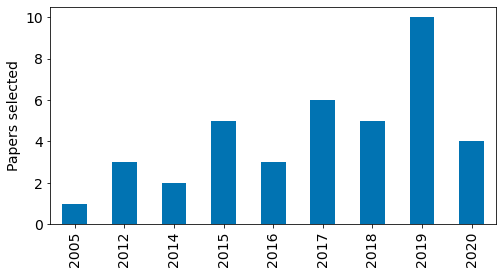

In [6]:
acceptedPapersDf.Year.value_counts().to_frame('Count').sort_index().plot.bar(legend=None)
plt.ylabel("Papers selected")
Savefig('PapersByYear')

# Inter-rater reliability

In [7]:
# Calculate the Inter-rater reliability (Cohen Kappa)

for rnd in range(2,allPreviousPapersDf.Round.max()+1):
    papersDf=(allPreviousPapersDf.query('Round=={}'.format(rnd))
              [['P','C']]
              .fillna(0)
              .applymap(lambda x: int(x) > 6 ) # We're only interested in accept or not.
             )
    matrix,bins= ir.to_table(papersDf)
    proportionAgreed=np.trace(matrix) / matrix.sum().sum()
    print( "Round {}: {:.0%} agreement\n{}\n{}".format(rnd,proportionAgreed,ir.cohens_kappa(matrix),matrix) )

Round 2: 100% agreement
                  Simple Kappa Coefficient
              --------------------------------
              Kappa                        nan
              ASE                          nan
              95% Lower Conf Limit         nan
              95% Upper Conf Limit         nan

                 Test of H0: Simple Kappa = 0

              ASE under H0                 nan
              Z                            nan
              One-sided Pr >  Z            nan
              Two-sided Pr > |Z|           nan

[[140.]]
Round 3: 100% agreement
                  Simple Kappa Coefficient
              --------------------------------
              Kappa                        nan
              ASE                          nan
              95% Lower Conf Limit         nan
              95% Upper Conf Limit         nan

                 Test of H0: Simple Kappa = 0

              ASE under H0                 nan
              Z                            nan
        

(13, 13)

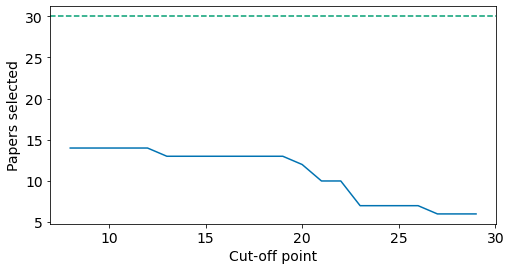

In [8]:
# After Round 3, we plot the number of accepted papers we get for different citation cut-offs.

def CitationsNeeded(year, **kwargs):
    req=kwargs['req']
    return req / 2 if year >= 2020 else (2020 - year) * req

round3Df=acceptedPapersDf.query('Round<=3')
pd.Series({ req: (round3Df.Citations >= round3Df.Year.apply(CitationsNeeded, req=req)).sum()
 for req in range(8, 30)}).plot()
plt.xlabel("Cut-off point")
plt.ylabel("Papers selected")
plt.axhline(y=30, color='C2', linestyle='--')
Savefig('CitationLimits')

# Points on the graph: How many citations as a result of chosing 19, 18?
((round3Df.Citations >= round3Df.Year.apply(CitationsNeeded, req=19)).sum(), 
 (round3Df.Citations >= round3Df.Year.apply(CitationsNeeded, req=18)).sum())

In [9]:
#So, choose 19:
chosenPapersDf=(acceptedPapersDf.assign( citationsRequired=acceptedPapersDf.Year.apply(CitationsNeeded, req=19) )
                .query('Citations >= citationsRequired'))
print(len(chosenPapersDf))

20


# Clustering

Use the 'related articles' list as a closeness measure for clustering the papers:

In [10]:
# Now we want, for each paper, in a column, the related papers as a map, key the Related ID, 
#   value the position of that related paper in the list.

# This takes a long time.
def RelatedPaperMap(relatedId):
    allRelatedPapers= GetPapers(RelatedQuery(relatedId))
    return {RelatedRef(p) : idx for idx, p in enumerate(allRelatedPapers)}

papersWithRelatedPapersListDf=(chosenPapersDf
                              .assign(Associations=[RelatedPaperMap(paper.Related) 
                                                   for paper in chosenPapersDf.itertuples()])
                              )

Retrieving 101 papers for {'q': 'related:KTJVwmlR8x0J:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:Q-WKLBC14wsJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:icr2IHptam0J:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:zi7zWlch-NYJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:kKM6ENmoT-AJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:_sbBVcHUDesJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:HVeYv2vUlgUJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:5X52iv58ywkJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:MVAS5fI7TuwJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:XWUPto6hd1YJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:4Lfb3qkBs9EJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:LvZu3xXSysYJ:scholar.google.com/'}
Retrieving 101 papers for {'q': 'related:rloYuefApRgJ:scholar.google.com/'}
Retrieving 1

In [11]:
#The Google queries take a long time and can cost money. 
#To make this repeatable we 'comment out' the slow parts by changing the cell type to 'Raw NB Convert'; 
# to redo the queries, convert them back again to Code.

with open( "papersWithRelatedPapers.p", "wb" ) as outFile:
    pickle.dump( papersWithRelatedPapersListDf, outFile )

In [22]:
with open( "papersWithRelatedPapers.p", "rb" ) as inFile:
    papersWithRelatedPapersListDf=pickle.load( inFile )

len(papersWithRelatedPapersListDf)

20

In [26]:
# Create a unique short name for each paper:
def CiteDescription(paper):
    # E.g. Acar+2016
    authorSurnames=re.split(r'[ ,]*[A-Z]* ', paper.Authors)[1:]
    authorCite=(authorSurnames[0] if len(authorSurnames)==1 
            else '&'.join(authorSurnames) if len(authorSurnames)==2
            else authorSurnames[0] + '+')
    return '{}{:d}'.format(authorCite, paper.Year)

#Add 'a','b' etc to the end to differentiate repeated descriptions ('Acar+2016a')
baseDescriptions=[CiteDescription(p) for p in papersWithRelatedPapersListDf.itertuples()]

# Kludge: Google Scholar doesn't have space for third author in Bednar, Spiekermann et al. 
papersWithRelatedAndCitesDf=(papersWithRelatedPapersListDf
            .assign(Cite=[ # 'Bednar+2019' if 'Bednar' in name else
                name + ['','a','b','c','d','e','f','g'][len([earlierName for earlierName in baseDescriptions[0:idx] if earlierName==name])]
     for idx, name in enumerate(baseDescriptions)]))

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
from scipy.spatial.distance import pdist
# Perform Agglomerative clustering

# pdist is the distance metric between two papers: 
# pdist's distance function receives two arrays containing the elements of two rows 
# of the dataframe. The array index of the items we want is the column index in the dataframe:
theAssociationsLoc=papersWithRelatedAndCitesDf.columns.get_loc("Associations") # e.g. 11
theIdLoc=papersWithRelatedAndCitesDf.columns.get_loc("Related")
NOT_ASSOCIATED=101 # Distance for items not in the 'associated papers' list of either papers considered.

def Distance(paper1, paper2):
    return min(paper1[theAssociationsLoc].get(paper2[theIdLoc], NOT_ASSOCIATED),
               paper2[theAssociationsLoc].get(paper1[theIdLoc], NOT_ASSOCIATED))

# The linkage method choses how each two clusters are compared for distance:
#       single, complete, weighted, average, ward
#‘ward’ minimizes the variance of the clusters being merged.
#‘average’ uses the average of the distances of each observation of the two sets.
#‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.
#‘single’ uses the minimum of the distances between all observations of the two sets.

Z = linkage(pdist(papersWithRelatedAndCitesDf, Distance), 'ward', optimal_ordering=False)

In [28]:
# Bit more magic, to get the cluster numbers (1,2,3...) for each paper:
clusterCutoff=NOT_ASSOCIATED-1 # Tweek to get an acceptable number of clusters.
clusteredPapersDf=(papersWithRelatedAndCitesDf.
                             assign(Cluster = fcluster(Z, t=clusterCutoff, criterion='distance') # t chosen to correspond to the x-axis separate point above.
                                   )
                            )
# Most of the clusters aren't interesting. Create 'groups' from the ones with more than 2 elements:
clusterSizes=clusteredPapersDf['Cluster'].value_counts()
groupMap=(clusterSizes[clusterSizes>2].to_frame()
            .assign(Group=lambda df: range(1,len(df)+1))
            ['Group']
                   )

def Group(cluster):
    return groupMap.get(cluster,0)
    
NumGroups=groupMap.max()
NumGroups

2

In [29]:
def NodeColour(n):
    # Answer a colour for this node. 
    # There's a colour for the unclustered nodes:
    if Z[n-len(clusteredPapersDf)][2] > clusterCutoff: 
        return 'C0'
    # otherwise follow the tree to a paper and see what group that is in.
    while n >= len(clusteredPapersDf):
        n=int(Z[n-len(clusteredPapersDf)][0])
    return 'C{}'.format(Group(clusteredPapersDf.iloc[n].Cluster))

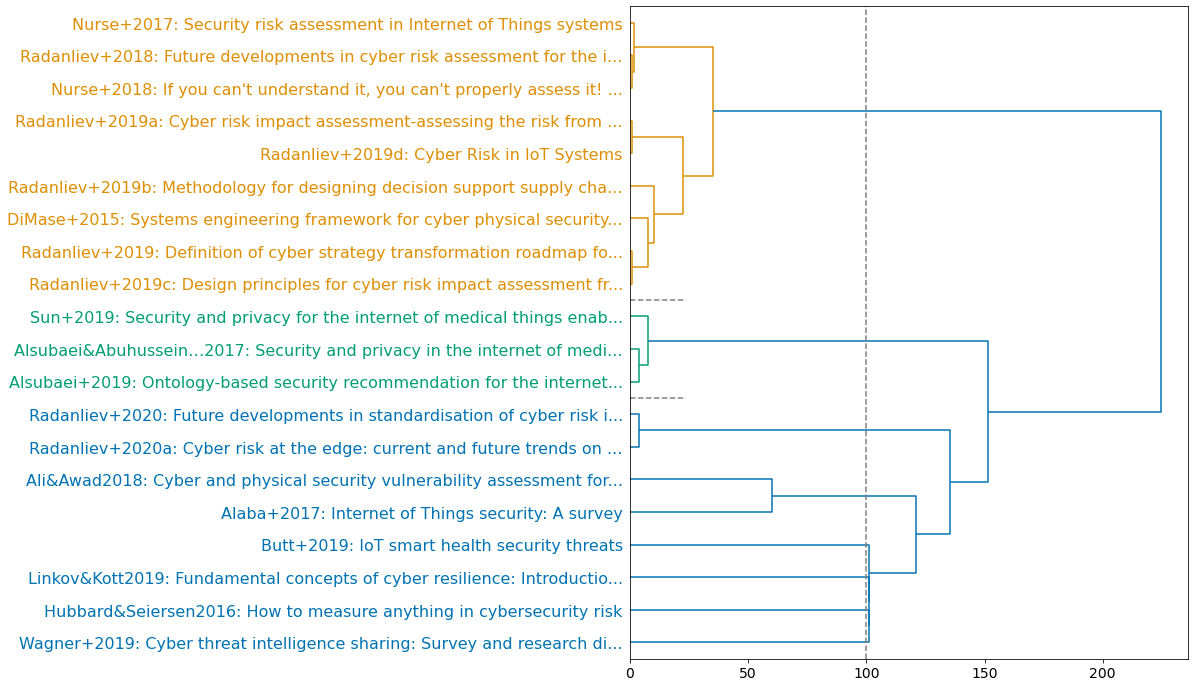

In [30]:
plt.figure(figsize=(10, 12))
longLabels=['{}: {}'.format(p.Cite, p.Title) for p in clusteredPapersDf.itertuples()]
MAX_TITLE_LENGTH=70
truncatedLabels=[label[:MAX_TITLE_LENGTH] + ('...' if len(label) > MAX_TITLE_LENGTH else '')
                 for label in longLabels
                ]
                            
dn = dendrogram(Z, 
                orientation='right', 
                leaf_font_size=16, 
                #count_sort='descending', # Tweek sorting to give good arrangement. 
                link_color_func=NodeColour,
                distance_sort='descending'
               )

# Kludge the labels to the group color used in the cluster diagram, and add a separator between groups

yTicks, yTickLabels = plt.yticks()
LabelOrder=[int(i.get_text()) for i in yTickLabels] # Top to bottom.

currentGroup=0
for i in yTickLabels:
    itemNumber=int(i.get_text())
    thisItemsGroup=Group(clusteredPapersDf.iloc[itemNumber].Cluster)
    if thisItemsGroup != currentGroup:
        if True: # currentGroup != 0:
            # Draw a line here:
            plt.axhline(y=i.get_position()[1] - 5, color='grey', xmax=0.1, linestyle='--')
        currentGroup = thisItemsGroup
    i.set_color( 'C{}'.format(thisItemsGroup)) 
    i.set_text(truncatedLabels[itemNumber])
plt.yticks(yTicks, labels=yTickLabels)

plt.axvline(x=clusterCutoff, color='grey', linestyle='--')

Savefig('clusters')

In [31]:
# List of triplets: URL, color, text for each label above, in top to bottom order:
Links=[p.Link for p in clusteredPapersDf.itertuples()]
LabelList=[(Links[LabelOrder[i]], matplotlib.colors.to_hex(item.get_color()), item.get_text()) 
           for i, item in enumerate(yTickLabels)][::-1]
# Kludge to get Jupyter to display html:
class Shout(object):
    def _repr_html_(self):
        return '<br>'.join(['<a href="{}" style="color:{}">{}</a>'.format(*triplet) for triplet in LabelList])    
Shout()

# Citation map

We use the 'cited by' functionality to track citation links between the papers:

In [32]:
def CitingPapers(paperSeries):
    # Use WellCitedPapers, because we're only interested in links between those papers:
    allCitingPapers= WellCitedPapers(GetPapers({'cites': paperSeries.Key}))
    return [paper.Key for paper in allCitingPapers.itertuples()]

# This takes a long time...
papersWithClustersAndCitedByDf=(clusteredPapersDf
                                .assign(CitedBy=[CitingPapers(paper) 
                                                 for paper in clusteredPapersDf.itertuples()]
                                       ))

Retrieving 124 papers for {'cites': '2158158161114378793'}
Retrieving 34 papers for {'cites': '856727435201930563'}
Retrieving 104 papers for {'cites': '7884234468971956873'}
Retrieving 41 papers for {'cites': '15490167577412579022'}
Retrieving 26 papers for {'cites': '16163323237889647504'}
Retrieving 22 papers for {'cites': '16937427700442842878'}
Retrieving 19 papers for {'cites': '402742775937259293'}
Retrieving 20 papers for {'cites': '705795199300173541'}
Retrieving 22 papers for {'cites': '17027613155545731121'}
Retrieving 120 papers for {'cites': '6230626243802260829'}
Retrieving 113 papers for {'cites': '15110423003858188256'}
Retrieving 16 papers for {'cites': '14324492556190021166'}
Retrieving 24 papers for {'cites': '1776037729542888110'}
Retrieving 195 papers for {'cites': '2030156502610964061'}
Retrieving 60 papers for {'cites': '14386747336759593166'}
Retrieving 77 papers for {'cites': '6871428980662632846'}
Retrieving 200 papers for {'cites': '7192314918966201656'}
Retr

In [33]:
with open( "papersWithCitedBy.p", "wb" ) as outFile:
    pickle.dump( papersWithClustersAndCitedByDf, outFile )

In [34]:
with open( "papersWithCitedBy.p", "rb" ) as inFile:
    papersWithClustersAndCitedByDf=pickle.load( inFile )
len(papersWithClustersAndCitedByDf)

20

In [35]:
workingDf=(papersWithClustersAndCitedByDf.copy()
           .set_index(['Key'], drop=False)
          )

edges=[(cFrom, paper.Key) for paper in workingDf.itertuples() 
         for cFrom in paper.CitedBy if cFrom in workingDf.Key.values 
     ]

G = nx.DiGraph()
G.add_edges_from(edges)

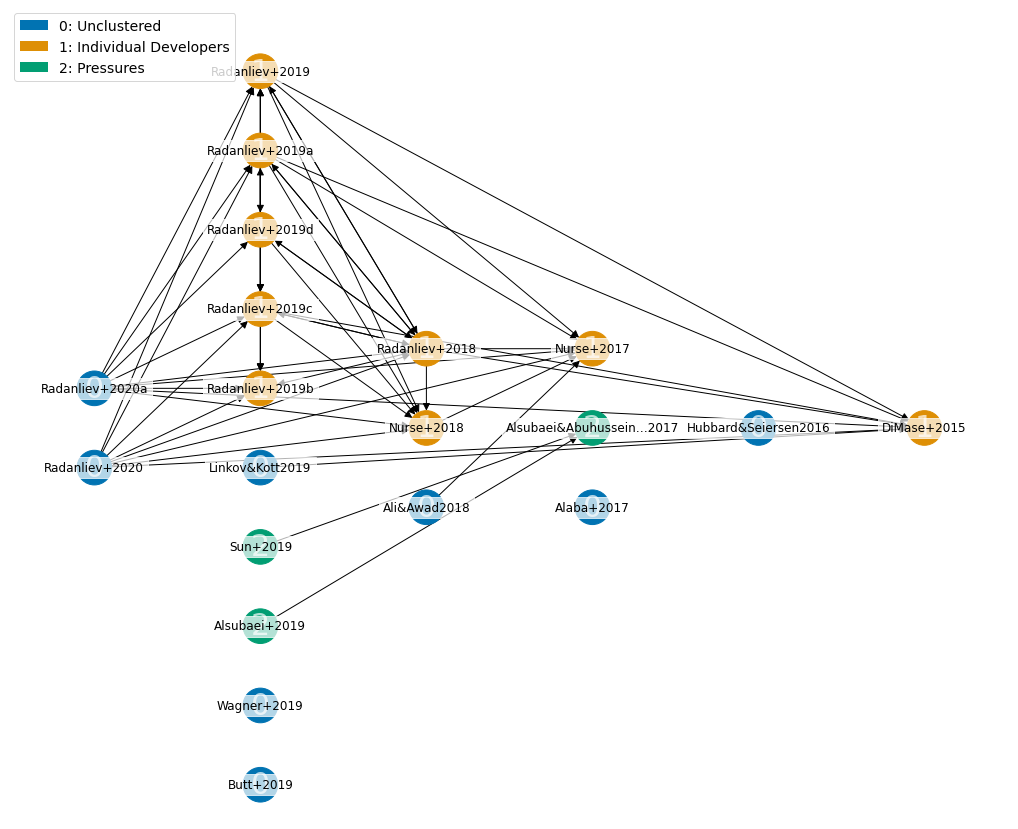

In [37]:
# Use a columns layout, where each column is a year, with the latest years on the left:
def Subset(paper):
    return 2022-paper.Year if paper.Year > 2015 else 2022-2015
G.add_nodes_from([(paper.Key, {'subset': Subset(paper)}) for paper in workingDf.itertuples()])
positions=nx.multipartite_layout(G)

# Move the items for some years up slightly so the texts don't overlap:
#delta=0.05
#positions={k: (np.array([pos[0],pos[1]+delta]) if workingDf.loc[k].Year in (2020,2018,2016) else pos) 
#           for k, pos in positions.items()}

# And move Hadar+2018 out of the way so it doesn't look as though it has lots of links:
#hadar=positions['9873211921093443394']
#positions['9873211921093443394']=(hadar[0],hadar[1]-0.85)

fig=plt.figure(figsize =(18, 15))

# We want two lots of node labels, one with the group numbers large, in white, and underneath the correct ones.
# So draw the group labels in the main network drawing process, and add the paper titles afterwards:

nx.draw_networkx(G,
                 # Need to specify explicitly the nodes, even though they're in G, to ensure ordering:
                 nodelist=[paper.Key for paper in workingDf.itertuples()],
                 node_color=['C{}'.format(Group(paper.Cluster)) for paper in workingDf.itertuples()], 
                 pos=positions, 
                 labels={paper.Key: Group(paper.Cluster) for paper in workingDf.itertuples()},
                 font_size=30,
                 font_color=(1,1,1,0.7),
                 node_size=1200,
                 arrowsize=15
                )

nx.draw_networkx_labels(G,
                 pos=positions, 
                 labels={paper.Key: paper.Cite for paper in workingDf.itertuples()},
                 bbox=dict(facecolor=(1,1,1,0.7), edgecolor=(1,1,1,0.7)),
                )    

groupNames={0: 'Unclustered', 2: 'Pressures', 1: 'Individual Developers', 3: 'Privacy'}
plt.legend(handles=[matplotlib.patches.Patch(facecolor='C{}'.format(i), label='{}: {}'.format(i, groupNames[i])) 
                    for i in range(0,NumGroups+1)])

## Magic to remove bounding box:
for spine in plt.gca().spines.values():
    spine.set_visible(False)
Savefig('citationLinks')

# List of authors and venues

Google Scholar isn't good at author lists and venues. Save as a spreadsheet and fix them manually.

In [ ]:
papersWithClustersAndCitedByDf[['Key','Cite','Round','Citations','Year','Title', 'Authors','Link','Snippet']].to_excel('SelectedPapers.xlsx')

In [ ]:
!open SelectedPapers.xlsx
assert(False) # And STOP!

In [ ]:
!open SelectedPapersSaved.xlsx

... then add Venue and Authors columns to SelectedPapers.xlsx and save it as SelectedPapersSaved.xlsx
This has to be done manually, as Scholar truncates the author list and isn't very clear on venues.

In [ ]:
venuesDf=pd.read_excel('SelectedPapersSaved.xlsx')
len(venuesDf)

In [ ]:
# List of venues:
venuesDf.Venue.value_counts()

In [ ]:
# Table of all authors with more than one paper. 
# Save to a spreadsheet as the easiest way to create a table.
(venuesDf
    .assign(Author=venuesDf.Authors.str.split(','))
    .explode('Author')
    .assign(Author=lambda df: df.Author.str.strip())
    [['Author']] 
    .value_counts()
    .to_frame('Count')
    .query('Count>1')
    .to_excel('Authors.xlsx')
)
!open authors.xlsx

In [ ]:
assert(False)

In [ ]:
!open ScholarUtils.py